# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1310s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1525, 32, 20, 3)
(1525, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
382/382 [==============================] - 8s 8ms/step - loss: 2.2225 - accuracy: 0.2806
Epoch 2/500
382/382 [==============================] - 3s 8ms/step - loss: 1.4971 - accuracy: 0.5014
Epoch 3/500
382/382 [==============================] - 3s 8ms/step - loss: 1.0716 - accuracy: 0.6722
Epoch 4/500
382/382 [==============================] - 3s 8ms/step - loss: 0.8690 - accuracy: 0.7324
Epoch 5/500
382/382 [==============================] - 3s 8ms/step - loss: 0.7551 - accuracy: 0.7674
Epoch 6/500
382/382 [==============================] - 3s 8ms/step - loss: 0.7404 - accuracy: 0.7574
Epoch 7/500
382/382 [==============================] - 3s 8ms/step - loss: 0.6876 - accuracy: 0.7788
Epoch 8/500
382/382 [==============================] - 3s 8ms/step - loss: 0.6128 - accuracy: 0.8156
Epoch 9/500
382/382 [==============================] - 3s 8ms/step - loss: 0.5366 - accuracy: 0.8417
Epoch 10/500
382/382 [==============================] - 3s 8ms/step - loss: 0.5603 - accura

382/382 [==============================] - 3s 8ms/step - loss: 0.1265 - accuracy: 0.9651
Epoch 80/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1071 - accuracy: 0.9629
Epoch 81/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1158 - accuracy: 0.9642
Epoch 82/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1529 - accuracy: 0.9429
Epoch 83/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0953 - accuracy: 0.9629
Epoch 84/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1471 - accuracy: 0.9548
Epoch 85/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0902 - accuracy: 0.9745
Epoch 86/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1469 - accuracy: 0.9634
Epoch 87/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1505 - accuracy: 0.9610
Epoch 88/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1066 - accuracy: 

382/382 [==============================] - 3s 8ms/step - loss: 0.0666 - accuracy: 0.9837
Epoch 158/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0960 - accuracy: 0.9771
Epoch 159/500
382/382 [==============================] - 3s 9ms/step - loss: 0.0848 - accuracy: 0.9691
Epoch 160/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1156 - accuracy: 0.9697
Epoch 161/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1221 - accuracy: 0.9734
Epoch 162/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0661 - accuracy: 0.9781
Epoch 163/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0603 - accuracy: 0.9786
Epoch 164/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0686 - accuracy: 0.9821
Epoch 165/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0853 - accuracy: 0.9807
Epoch 166/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1367 - a

382/382 [==============================] - 3s 8ms/step - loss: 0.0629 - accuracy: 0.9846
Epoch 237/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0822 - accuracy: 0.9811
Epoch 238/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0422 - accuracy: 0.9877
Epoch 239/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0509 - accuracy: 0.9835
Epoch 240/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0437 - accuracy: 0.9853
Epoch 241/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0577 - accuracy: 0.9704
Epoch 242/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0771 - accuracy: 0.9821
Epoch 243/500
382/382 [==============================] - 3s 9ms/step - loss: 0.0411 - accuracy: 0.9906
Epoch 244/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0666 - accuracy: 0.9801
Epoch 245/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0551 - a

382/382 [==============================] - 3s 8ms/step - loss: 0.0831 - accuracy: 0.9792
Epoch 345/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0386 - accuracy: 0.9895: 0s - loss: 0
Epoch 346/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0475 - accuracy: 0.9850
Epoch 347/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0324 - accuracy: 0.9910
Epoch 348/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0373 - accuracy: 0.9869
Epoch 349/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0543 - accuracy: 0.9809
Epoch 350/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0416 - accuracy: 0.9916
Epoch 351/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0696 - accuracy: 0.9750: 0s - loss: 0.0
Epoch 352/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0643 - accuracy: 0.9819
Epoch 365/500
382/382 [==============================] - 

382/382 [==============================] - 3s 8ms/step - loss: 0.0338 - accuracy: 0.9883: 1s - l
Epoch 462/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0632 - accuracy: 0.9826
Epoch 463/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0355 - accuracy: 0.9919
Epoch 464/500
382/382 [==============================] - 3s 8ms/step - loss: 0.1482 - accuracy: 0.9802
Epoch 465/500
382/382 [==============================] - 3s 9ms/step - loss: 0.0366 - accuracy: 0.9873
Epoch 466/500
382/382 [==============================] - 3s 9ms/step - loss: 0.0409 - accuracy: 0.9850
Epoch 467/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0429 - accuracy: 0.9942
Epoch 468/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0409 - accuracy: 0.9883
Epoch 469/500
382/382 [==============================] - 3s 8ms/step - loss: 0.0293 - accuracy: 0.9927
Epoch 470/500
382/382 [==============================] - 3s 9ms/step - loss: 0.

### Learing result
 
* Visualization of the training and validation results

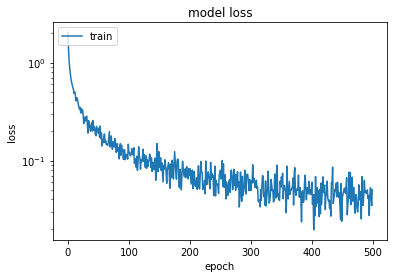

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\4_10_dig4_20210709-181251.jpg 4 -1


ziffer_sortiert_resize\7_10_dig6_20210727-150532.jpg 7 -1


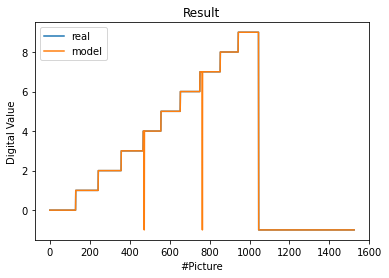

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpvgp1hneq\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpw7hjo_ie\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpw7hjo_ie\assets


dig1310s3q.tflite


63824

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.